## Burger's equation: One-step Method

In [1]:
import sys
#sys.path.append('/Users/josorior/Documents/UW/research/keql/KEQL/source')
#sys.path.append('/Users/yasaminjalalian/Repos/KEQL/source')
sys.path.append('/home/juanfelipe/Desktop/research/keql/source')

In [2]:
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [3]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.kernel_ridge import KernelRidge
from tqdm import tqdm
from parameter_learning import *
from plotlib import *
from models import * 
from kernels import *
from data_loader_Burgers5 import *
from loss import *
from utils import *

import jax.numpy as jnp
from jax import grad, jit
from jax.scipy.optimize import minimize
from jax.config import config; 
config.update("jax_enable_x64", True)

from functools import partial # for jit to make codes faster

(100, 320)


In [4]:
# Import values from 2-step
two_step_dict = np.load('data/two_step_dict.npy', allow_pickle=True)
two_step_dict = two_step_dict.item()

In [5]:
two_step_dict

{'optim_sgm_u': array([2.18616479, 2.03157033, 3.27856487]),
 'optim_nugget_u': array([1.e-14, 1.e-08, 1.e-08]),
 'rkhs_u': [14106394.445817092],
 'optim_sgm_P': 0.1562004188846055,
 'optim_nugget_P': 1e-08,
 'nugget_P': 1e-07,
 'rkhs_P_train': 0.052934892693538675,
 'f_gh_tr_pred': array([-0.00949953, -0.01336055, -0.01590136, ..., -0.00150661,
        -0.00066893,  0.00159723]),
 'rkhs_P_test': 0.052935556629889795}

### Cost function

In [6]:
two_step_dict.get('optim_sgm_u')

array([2.18616479, 2.03157033, 3.27856487])

Compute `Kphiphi` and its corresponding regularizing matrix `R`

In [7]:
# Create Kphiphi
sigma_K = jnp.array(two_step_dict.get('optim_sgm_u'))
# Create auxiliary functions per example. 
Kphiphis = [Kphiphi_Burgers_assembly( X_tr[i*N_tr:(i+1)*N_tr] , k = 'Gaussian2D', k_param = sigma_K[i]) for i in range(m)]

In [8]:
Rs = [jnp.diag(jnp.diag(Kphiphis[i])) for i in range(m)]

Training data

In [9]:
# First column in Gamma(S_N,S_N)
X = X_tr # (N_train*m, 1)

# Second column in Gamma(S_N,S_N)
U = U_tr.T.reshape(N_tr*m,1) # (N_tr*m, 1)

# f(X_N)
f = U_t_tr.T.reshape(N_tr*m,1)

Initial guess: `Z_warm`

In [10]:
# Load gradients from 2-step
U_x_tr_pred  = np.load('data/U_x_tr_pred.npy')
U_xx_tr_pred = np.load('data/U_xx_tr_pred.npy')
# Build Z_warm
Z_warm = np.hstack([U_x_tr_pred.T.reshape(N_tr*m,1), U_xx_tr_pred.T.reshape(N_tr*m,1)])
Z_warm = Z_warm.T.flatten()

In [11]:
two_step_dict['rkhs_u'] = np.zeros(m)

In [12]:
np.zeros(3)

array([0., 0., 0.])

In [13]:
alpha_K = 1e-7 # Nugget 
Kphiphis = [Kphiphis[i] + alpha_K*Rs[i] for i in range(m)] 

ZZ = jnp.hstack((U.reshape(-1,1),Z_warm.reshape(2,m*N_tr).T))
# Compute the RKHS norm of u's of first iteration
for i in range(m):
    Z_0i = jnp.reshape(ZZ[N_tr*i:N_tr*(i+1),:].T, (N_tr*3,1))  
    c = jnp.linalg.solve(Kphiphis[i],Z_0i)
    rkhs_u_0i = jnp.reshape(jnp.dot(Z_0i.T , c),())
    two_step_dict['rkhs_u'][i] = rkhs_u_0i

Create objective function `L`

In [14]:
def L(Z, X, U, f, Kphiphis, Rs, two_step_dict, lmbd):
    """Cost function for 1-step method.
    
    Args:
        Z: Vector of optimization variables in the cost function. 2*m*N
        X: List of mN points of dimension d.
        U: List of mN values of functions u^(1),...u^(N).
        f: List of mN values of functions u^(1),...u^(N).
        R: Matrices that regularizes each Kphiphi.
        two_step_dict: Dictionary with values from 2-step.
        lmbd: Lagrange multiplier in the loss function. 
    Returns:
        scalar: a cost of this solution.    
    """ 
    m = 3
    N = X.shape[0]
    # Re-shape Z into a matrix
    Z = Z.reshape(2,N_tr*m).T
    ### First term

    # Build S_N
    S1 = jnp.hstack([X,U])
    S = jnp.hstack([S1,Z])

    # Scaling S_N
    scaler_s_train = MinMaxScaler()
    S = scaler_s_train.fit_transform(S)
    # Gamma(S_N,S_N) 
    optim_sgm_P = two_step_dict.get('optim_sgm_P')
    Gamma = K(Gaussian, S, S, optim_sgm_P)
    nugget_P = two_step_dict.get('nugget_P')
    Gamma = Gamma + nugget_P*jnp.eye(jnp.size(Gamma,0)) 
    #print("cond(Gamma) = ", jnp.linalg.cond(Gamma)) # Condition number of Gamma

    # (Gamma(S_N,S_N) + alpha_Gamma*I)^-1 * f
    b = jnp.linalg.solve(Gamma,f).flatten()

    # First term
    L1 = jnp.dot(f.flatten() , b) / two_step_dict.get('rkhs_P_train')
    print("L1(Z_warm) = ", L1)


    ### Second term

    L2 = 0.

    alpha_K = 1e-7 # Nugget 
    #Kphiphis = [Kphiphis[i] + alpha_K*Rs[i] for i in range(m)] 
    #print("cond(Kphiphi) = ", jnp.linalg.cond(Kphiphis[0])) # Condition number

    
    ZZ = jnp.hstack([U,Z])
    for i in range(m):
        Z_i = jnp.reshape(ZZ[N_tr*i : N_tr*(i+1) , :].T,(N_tr * 3, 1)) 
        #print('Z_{}'.format(i),Z_i) 
        c = jnp.linalg.solve(Kphiphis[i],Z_i) 
        L2 += jnp.reshape(jnp.dot(Z_i.T , c),()) / two_step_dict.get('rkhs_u')[i] # NORMALIZATION MIGHT NOT BE NEEDED HERE IN THE 1.5 STEP METHOD
        #print(two_step_dict.get('rkhs_u'))
        #print("L2_(Z_warm)_{} = ".format(i+1),jnp.reshape(jnp.dot(Z_i.T , c),()) / two_step_dict.get('rkhs_u'))
    # Compute the total loss per epoch - It's going down !
    # Compute the loss per function u epoch  
    # Compute the total loss normalized per epoch
    # Compute the loss per function u normalized per epoch

    print("L2(Z_warm) = ",L2)

    return L1 + lmbd*L2 # Return loss.

- Use 10 for training and 1000 in total as ghosts.
- 5 - 20
- 10 - 100
- 50 - 200
- 100 - 500
- but using 10 solutions sampled from a GP. Or try ChatGPT.

#### Training data and warm up

In [15]:
L(Z_warm, X, U, f, Kphiphis, Rs, two_step_dict, lmbd = 1/m)

L1(Z_warm) =  1.0000073047202174
L2(Z_warm) =  3.0


Array(2.0000073, dtype=float64)

In [16]:
lmbd_min = 1/m 

#### LBFGS

In [17]:
# Load the warm-up 
Z = np.copy(Z_warm) 

In [18]:
result = minimize(L, Z, args=(X, U, f, Kphiphis, Rs, two_step_dict, 1/m), method= 'BFGS')

L1(Z_warm) =  Traced<ConcreteArray(1.0000073047202174, dtype=float64)>with<JVPTrace(level=2/0)> with
  primal = Array(1.0000073, dtype=float64)
  tangent = Traced<ShapedArray(float64[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float64[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f64a042b4b0>, in_tracers=(Traced<ShapedArray(float64[]):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.052934892693538675, dtype=float64):JaxprTrace(level=1/0)>), out_tracer_refs=[<weakref at 0x7f64a035c1d0; to 'JaxprTracer' at 0x7f64a035c270>], out_avals=[ShapedArray(float64[])], primitive=pjit, params={'jaxpr': { lambda ; a:f64[] b:f64[]. let c:f64[] = div a b in (c,) }, 'in_shardings': (UnspecifiedValue, UnspecifiedValue), 'out_shardings': (UnspecifiedValue,), 'resource_env': None, 'donated_invars': (False, False), 'name': 'true_divide', 'keep_unused': False, 'inline': True}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x7f64a

In [19]:
Z = result.x.reshape(2, N_tr*m).T

#### Evaluation of `Z`

In [20]:
# Load true gradients from 2-step
U_x_tr = np.load('data/U_x_tr.npy')
U_xx_tr = np.load('data/U_xx_tr.npy')
# Build true Z
Z_true = np.hstack([U_x_tr.T.reshape(N_tr * m,1), U_xx_tr.T.reshape(N_tr*m,1)])

#### Predictions of P

Recall on the Representer formula

$$
P^*(\cdot) = \Gamma(\cdot,S_N) \Gamma(S_N,S_N)^{-1} f(X_N)
$$

In [21]:
# Build S_N - Training data
S1 = jnp.hstack([X_tr, U])
S = jnp.hstack([S1, Z])
# Load gradients from 2-step
U_x_te_pred  = np.load('data/U_x_te_pred.npy')
U_xx_te_pred = np.load('data/U_xx_te_pred.npy')
s_test = np.hstack((X_te, U_te.T.reshape(-1,1), U_x_te_pred.T.reshape(-1,1), U_xx_te_pred.T.reshape(-1,1)))  # 30 * 4
f_train = U_t_tr.T.reshape(N_tr*m,1).flatten()
f_test = U_t_te.T.reshape(N_te*m,1).flatten()
scaler_s_train = MinMaxScaler()
s_train_s = scaler_s_train.fit_transform(S)
s_test_s = scaler_s_train.transform(s_test)

optim_sgm_P, optim_nugget_P = grid_search_RBF(s_train_s, f_train)

krr_optimal_P = KernelRidge(kernel='rbf', alpha = two_step_dict.get('optim_nugget_P'), gamma=1/(2*(two_step_dict.get('optim_sgm_P')**2))) 
krr_optimal_P.fit(s_train_s, f_train)
f_pred_train = krr_optimal_P.predict(s_train_s) 
f_pred_test = krr_optimal_P.predict(s_test_s)
f_train2 = -S[:,2]*S[:,3] + 0.01*S[:,4]
f_test2 = -s_test[:,2]*s_test[:,3] + 0.01*s_test[:,4]

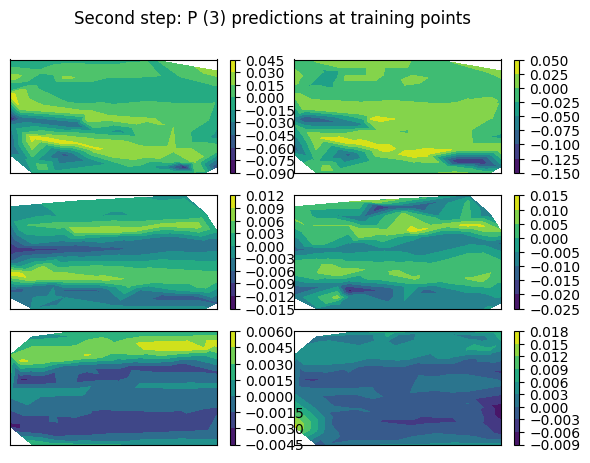

In [22]:
# Interpolant P^* at training points : P^*(hat S) vs. P(hat S)
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('Second step: P ({}) predictions at training points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(S[i*N_tr:(i+1)*N_tr,0], S[i*N_tr:(i+1)*N_tr,1], f_pred_train[i*N_tr:(i+1)*N_tr])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(S[i*N_tr:(i+1)*N_tr,0], S[i*N_tr:(i+1)*N_tr,1], f_train2[i*N_tr:(i+1)*N_tr])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

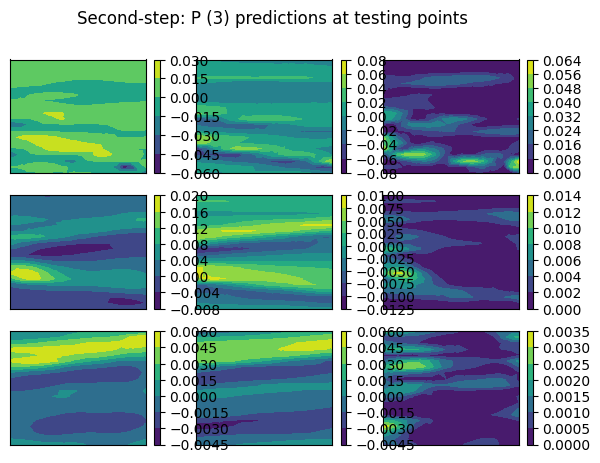

In [23]:
# Interpolant P^* at testing points : P^*(hat S) vs. P(hat S)
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 3, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('Second-step: P ({}) predictions at testing points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(s_test[i*N_te:(i+1)*N_te,0], s_test[i*N_te:(i+1)*N_te,1], f_pred_test[i*N_te:(i+1)*N_te])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(s_test[i*N_te:(i+1)*N_te,0], s_test[i*N_te:(i+1)*N_te,1], f_test2[i*N_te:(i+1)*N_te])
        plt.colorbar(axsi1, ax = axs[i,1])
        axsi2 = axs[i,2].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], np.abs(f_test2[i*N_te:(i+1)*N_te]-f_pred_test[i*N_te:(i+1)*N_te]))
        plt.colorbar(axsi2, ax = axs[i,2])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])
        axs[i,2].set_yticklabels([])
        axs[i,2].set_xticklabels([])
        axs[i,2].set_yticks([])
        axs[i,2].set_xticks([])

In [24]:
# NMSEs: P at training points and testing points
print('Normalized MSEs between P and P^ for {} functions'.format(m))
for i in range(m):
    n_mse_train = mean_squared_error(f_pred_train[i*N_tr:(i+1)*N_tr], f_train2[i*N_tr:(i+1)*N_tr])/mean_squared_error(f_pred_train[i*N_tr:(i+1)*N_tr]*0, f_train2[i*N_tr:(i+1)*N_tr])
    n_mse_test = mean_squared_error(f_pred_test[i*N_te:(i+1)*N_te], f_test2[i*N_te:(i+1)*N_te])/mean_squared_error(f_pred_test[i*N_te:(i+1)*N_te]*0, f_test2[i*N_te:(i+1)*N_te])
    print('m = {} nmse_train = {}'.format(i,n_mse_train))
    print('m = {} nmse_test = {}'.format(i,n_mse_test))

Normalized MSEs between P and P^ for 3 functions
m = 0 nmse_train = 0.6006644635305981
m = 0 nmse_test = 0.6042724447788815
m = 1 nmse_train = 0.5581451605228971
m = 1 nmse_test = 0.4947687104863518
m = 2 nmse_train = 0.5504981610447115
m = 2 nmse_test = 0.18906129979168107


In [ ]:
mses_P_all = []
for j in tqdm(range(5)):
    # Compute std per feature of s_train_s
    stds = np.std(S, axis = 0)
    beta = np.arange(0.0,0.25,0.05)
    scales = np.outer(beta, stds) 
    mses_P = []
    for i in tqdm(range(len(scales))):
        # Scales for current iteration
        scale = scales[i,:]
        # Copy s_train
        s_test = np.copy(S)
        # Perturb feature that contains u^* - Do this 10 times and average !!!
        s_test[:,2] = np.random.normal(S[:,2] , scale = scale[2])
        # Apply step one to perturbed u's 
        optim_sgm_u, alphas, optim_nugget_u = kernel_parameters_Gaussian_2D(X_tr, U_tr, N_tr)
        _, _, u_x_pred, u_xx_pred = predictions_Burgers_tr(X_tr, Gaussian2D, optim_sgm_u, alphas, N_tr)
        s_test[:,3] = u_x_pred.T.reshape(-1,1).flatten()
        s_test[:,4] = u_xx_pred.T.reshape(-1,1).flatten()
        # Scale the new s_test
        s_test_s = scaler_s_train.transform(s_test)
        # Compute predictions on test
        f_pred_test = krr_optimal_P.predict(s_test_s)
        # True test -> Why if I use this rule for s_test_s the bellow rule cannot be compared with f_pred_test
        f_true_test = -s_test[:,2]*s_test[:,3] + 0.01*s_test[:,4]
        # Compute mse per scale 
        mses_P.append(mean_squared_error(f_true_test,f_pred_test)/mean_squared_error(0*f_true_test,f_true_test))
# Plot - We have a vector of dimension 4 of scales vs. mses
    mses_P_all.append(mses_P)
mses_P_all = np.array(mses_P_all)
print(mses_P_all)
mean_mses_P_all = np.mean(mses_P_all, axis = 0)
plt.plot(beta,mean_mses_P_all,'.-')
plt.xlabel('noise level: percentage of std of u^*')
plt.ylabel('mse: f_pred vs. f_true')
plt.show()